#**Unsupervised Learning**


1.   **Image Segmentation**
2.   **Anomaly Detection**
3.   **Skin Detection**




---

### IMPORTS


In [ ]:
import numpy as np              # For numerical operations and array manipulations
import matplotlib.pyplot as plt # For plotting and visualization
import pandas as pd             # For data handling and CSV file reading
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.metrics import precision_score, recall_score, f1_score, silhouette_score  # For evaluation metrics
from sklearn.decomposition import PCA  # For dimensionality reduction (PCA for visualization)
import requests                 # For downloading images or data from URLs (used in Tasks 1 and 2)
from io import BytesIO          # For handling binary data streams (used with requests)
from PIL import Image           # For image processing (used in Tasks 1 and 2)
import cv2                      # For computer vision tasks
from sklearn.manifold import TSNE #Again useful for NL dimensionality reduction


##  Image Segmentation with Clustering

**Objective:** This task explores the application of unsupervised clustering techniques to partition an image into meaningful regions based on pixel similarities. By implementing algorithms like K-means and K-medoids, I will investigate how to automatically segment visual data, which is crucial for tasks like object recognition and image editing, offering a foundation for understanding pattern recognition in computer vision.

In [ ]:
url = "https://media.wired.com/photos/5b7c67dff521ce3ac9ba45e9/16:9/w_2240,h_1260,c_limit/post10%5Bhttps-_goo.gl_maps_g65Rg5BDBsQ2%5D-(1).jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = np.array(img)

img_resized = np.array(Image.fromarray(img).resize((100, 100)))
height, width, _ = img_resized.shape
pixels = img_resized.reshape(-1, 3).astype(float) / 255.0  # normalize

def rgb_to_ycbcr(rgb):
    r, g, b = rgb[:, 0], rgb[:, 1], rgb[:, 2]
    y = 0.299 * r + 0.587 * g + 0.114 * b
    cb = 0.5 * b - 0.1687 * r - 0.3313 * g + 0.5
    cr = 0.5 * r - 0.4187 * g - 0.0813 * b + 0.5
    return np.column_stack((y, cb, cr))

pixels_ycbcr = rgb_to_ycbcr(pixels)

features = pixels_ycbcr

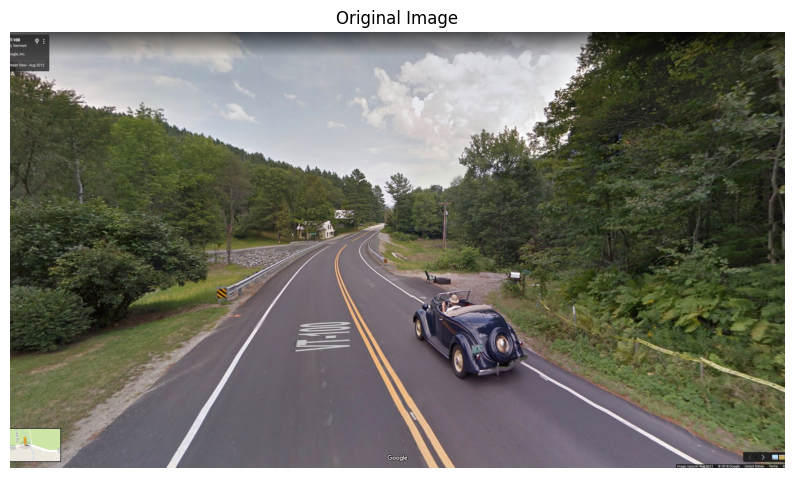

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.show()

<span style="color: purple; font-size: 20px;">**Task 1.1:**</span>

In this task, I will implement clustering algorithms to group data points based on their features. Our goal is to create functions for initializing and performing two popular clustering techniques. Follow these steps to complete the task:

-  Implement a smart **initialization method for K-means clustering** that selects initial centroids to improve convergence.
-  Develop the **K-means algorithm**, allowing for a custom initialization option to enhance clustering efficiency.
-  Create a **K-medoids algorithm**, which uses actual data points as cluster representatives instead of means, focusing on robustness to outliers.
-  Use NumPy for efficient vectorized operations to assign points to clusters and update centroids or medoids.



In [ ]:
def kmeanspp_init(X, k):
    n = X.shape[0]
    centroids = np.zeros((k, X.shape[1]))
    centroids[0] = X[np.random.randint(n)]
    distances = np.full(n, np.inf)

    for i in range(1, k): #Apply Loop to pick the k centroids
        # Update distances to nearest chosen centroid
        diff = X - centroids[i-1]
        d2 = np.linalg.norm(diff, axis=1) ** 2 #find squared Euclidean distance
        distances = np.minimum(distances, d2)

        # Choose next centroid with probability proportional to distance^2
        probs = distances / distances.sum()
        idx = np.random.choice(n, p=probs) #point farther from existing centroid have higher chance of being picked
        centroids[i] = X[idx]

    return centroids

def kmeans(X, k, max_iter=100, init='random'):
    n, d = X.shape
    if init == 'kmeanspp':
        centroids = kmeanspp_init(X, k)
    else:
        centroids = X[np.random.choice(n, k, replace=False)]

    for _ in range(max_iter):
        # Assign step, assign each point to the nearest centroid.
        diff = X[:, None, :] - centroids[None, :, :]
        d2 = np.linalg.norm(diff, axis=2) ** 2
        labels = np.argmin(d2, axis=1)

        # Update step
        new_centroids = centroids.copy()
        for j in range(k):
            mask = (labels == j) #Creates Boolean array (True/False) for all data points
            if np.any(mask):
                new_centroids[j] = X[mask].mean(axis=0)
            else:
                # Reinitialize empty cluster to a random data point
                new_centroids[j] = X[np.random.randint(n)]

        if np.allclose(new_centroids, centroids): #Check for convergence
            break
        centroids = new_centroids

    return labels, centroids

def kmedoids(X, k, max_iter=100):
    n, d = X.shape
    medoids_idx = np.random.choice(n, k, replace=False)
    medoids = X[medoids_idx]

    for _ in range(max_iter):
        # Assign each point to nearest medoid
        diff = X[:, None, :] - medoids[None, :, :] # shape of diff (n, k, d)
        dists = np.linalg.norm(diff, axis=2)
        labels = np.argmin(dists, axis=1)

        new_medoids_idx = medoids_idx.copy()
        medoid_set = set(medoids_idx.tolist())

        for j in range(k):
            cluster_idx = np.where(labels == j)[0]
            if cluster_idx.size == 0:
                # Reassign to a random non-medoid to avoid empty cluster
                candidates = np.setdiff1d(np.arange(n), np.array(list(medoid_set)))
                if candidates.size > 0:
                    choice = np.random.choice(candidates)
                    new_medoids_idx[j] = choice
                    medoid_set.add(choice)
                continue

            # Compute total distance from each point in cluster to all others in cluster
            Xc = X[cluster_idx]
            # Pairwise distances within cluster
            diff_c = Xc[:, None, :] - Xc[None, :, :]
            pdists = np.linalg.norm(diff_c, axis=2)
            total = pdists.sum(axis=1)
            best_local = cluster_idx[np.argmin(total)]
            new_medoids_idx[j] = best_local

        if np.array_equal(new_medoids_idx, medoids_idx):
            break

        medoids_idx = new_medoids_idx
        medoids = X[medoids_idx]

    return labels, medoids


In [ ]:
#We have defined the implementation of the Agglomerative Clustering algorithm for you.

def agglomerative(X, k):
    n = X.shape[0]
    # since n is large, lets sample a subset
    if n > 1000:
        sample_idx = np.random.choice(n, 1000, replace=False)
        X_sample = X[sample_idx]
    else:
        X_sample = X
        sample_idx = np.arange(n)

    m = X_sample.shape[0]
    clusters = list(range(m))
    dist_matrix = np.linalg.norm(X_sample[:, np.newaxis] - X_sample, axis=2)

    while len(set(clusters)) > k:

        # find closest pairs
        min_dist = np.inf
        pair = (-1, -1)
        for i in range(m):
            for j in range(i+1, m):
                if clusters[i] != clusters[j] and dist_matrix[i, j] < min_dist:
                    min_dist = dist_matrix[i, j]
                    pair = (clusters[i], clusters[j])

        # merge
        for i in range(m):
            if clusters[i] == pair[1]:
                clusters[i] = pair[0]

    # map to labels
    unique_clusters = list(set(clusters))
    label_map = {c: i for i, c in enumerate(unique_clusters)}
    sample_labels = np.array([label_map[c] for c in clusters])

    # assign all points to nearest sample cluster centers (approximate)
    centers = np.array([X_sample[sample_labels == i].mean(axis=0) for i in range(k)])
    distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
    labels = np.argmin(distances, axis=1)

    return labels

In [ ]:
val_k = 5

labels_kmeans, centroids_kmeans = kmeans(features, k=val_k, init='kmeanspp')
labels_kmedoids, medoids = kmedoids(features, k=val_k)
labels_agg = agglomerative(features, k=val_k)

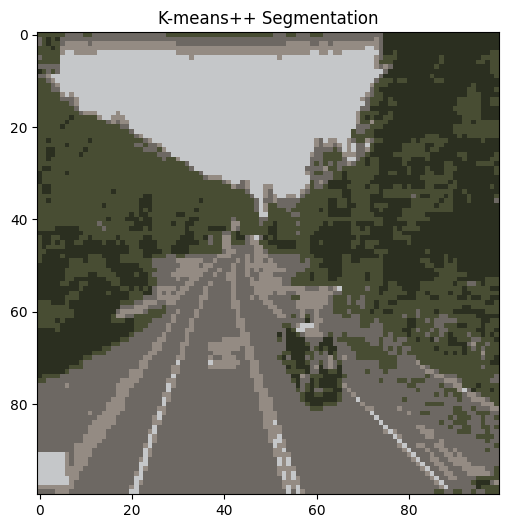

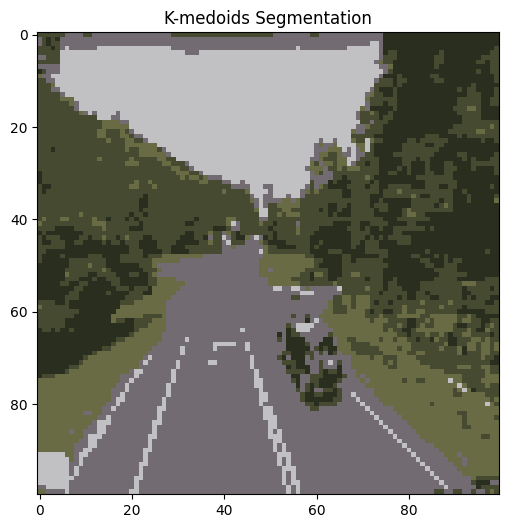

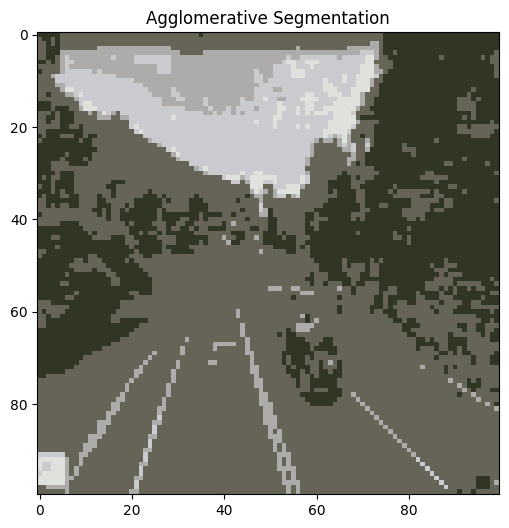

In [ ]:
def visualize_segmentation(img, labels, k, title):
    segmented = np.zeros_like(img)
    for i in range(k):
        mask = (labels == i).reshape(img.shape[:2])
        color = img[mask].mean(axis=0)
        segmented[mask] = color.astype(int)
    plt.figure(figsize=(8, 6))
    plt.imshow(segmented)
    plt.title(title)
    plt.show()

visualize_segmentation(img_resized, labels_kmeans, val_k, 'K-means++ Segmentation')
visualize_segmentation(img_resized, labels_kmedoids, val_k, 'K-medoids Segmentation')
visualize_segmentation(img_resized, labels_agg, val_k, 'Agglomerative Segmentation')

<span style="color: purple; font-size: 20px;">**Task 1.2:**</span>

In this task, we will implement a function to evaluate the quality of clustering by calculating the **Within-Cluster Sum of Squares (WCSS)**.  
This metric measures the compactness of clusters. Follow these steps to complete the task:

- Define a function that takes data points (`X`), cluster labels, and cluster centers (centroids or medoids) as inputs.  
- Compute WCSS using the formula:

$$
\text{WCSS} = \sum_{i=1}^{k} \sum_{x \in C_i} \| x - c_i \|^2
$$

where \\( k \\) is the number of clusters, \\( C_i \\) is the set of points in cluster \\( i \\), \\( x \\) is a point, and \\( c_i \\) is the cluster center.  

- Use NumPy to calculate squared Euclidean distances between points and their assigned centers.  
- Handle edge cases, such as empty clusters, by skipping them in the summation.  
- Return the total WCSS score as a float.  




In [ ]:
def calculate_wcss(X, labels, centroids_or_medoids):
    """
    Calculate Within-Cluster Sum of Squares manually.

    Parameters:
    - X: numpy array of shape (n_samples, n_features) containing the data points
    - labels: numpy array of shape (n_samples,) containing cluster labels
    - centroids_or_medoids: numpy array of shape (n_clusters, n_features) containing cluster centers

    Returns:
    - wcss: float, the total WCSS score
    """
    n_clusters = len(np.unique(labels))
    wcss = 0.0

    for i in range(centroids_or_medoids.shape[0]):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            wcss += np.sum(np.linalg.norm(cluster_points - centroids_or_medoids[i], axis=1) ** 2)


    return wcss

K-means++ Metrics:
  Silhouette Score: 0.4996
  Within-Cluster Sum of Squares (WCSS): 27.0670

K-medoids Metrics:
  Silhouette Score: 0.4810
  Within-Cluster Sum of Squares (WCSS): 33.6279

Agglomerative Metrics:
  Silhouette Score: 0.4444
  Within-Cluster Sum of Squares (WCSS): 50.5240



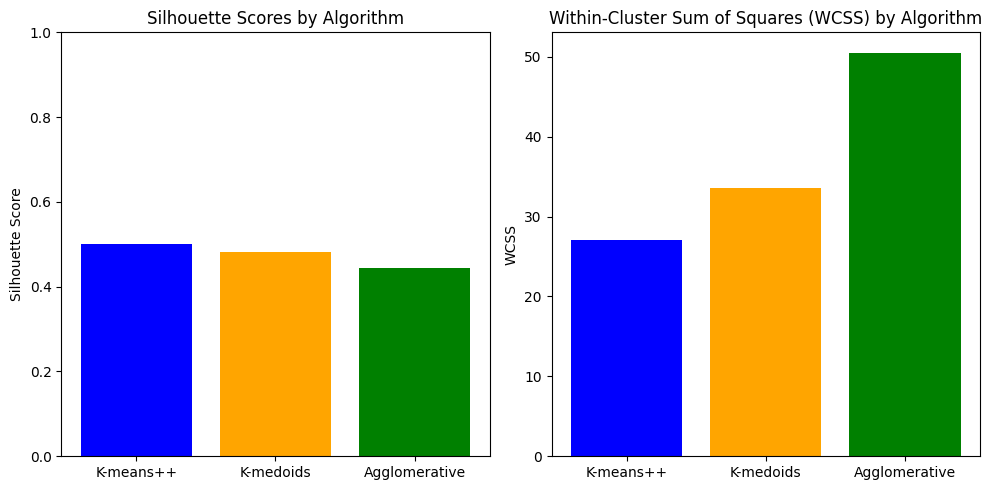

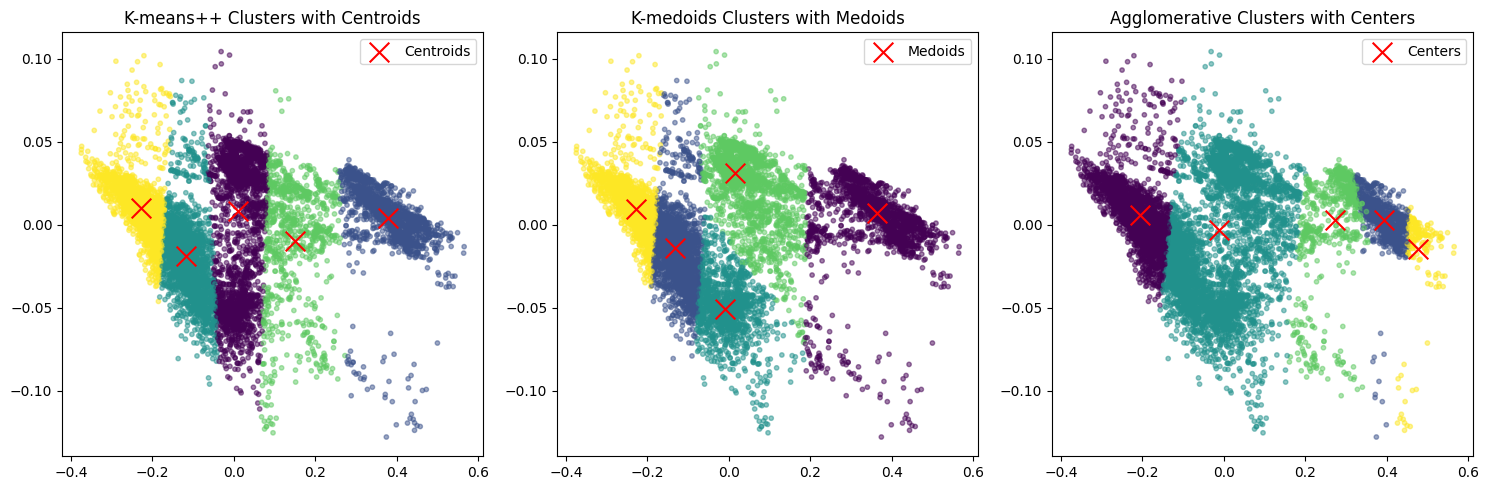

In [ ]:
def calculate_metrics(X, labels, centroids_or_medoids=None, algorithm_name=""):
    if len(set(labels)) < 2:
        sil_score = 0
    else:
        sil_score = silhouette_score(X, labels)

    if centroids_or_medoids is not None and len(np.unique(labels)) > 0:
        wcss = calculate_wcss(X, labels, centroids_or_medoids)
    else:
        wcss = 0.0

    print(f"{algorithm_name} Metrics:")
    print(f"  Silhouette Score: {sil_score:.4f}")
    print(f"  Within-Cluster Sum of Squares (WCSS): {wcss:.4f}\n")
    return sil_score, wcss

sil_kmeans, wcss_kmeans = calculate_metrics(features, labels_kmeans, centroids_kmeans, "K-means++")
sil_kmedoids, wcss_kmedoids = calculate_metrics(features, labels_kmedoids, medoids, "K-medoids")
sil_agg, wcss_agg = calculate_metrics(features, labels_agg, np.array([features[labels_agg == i].mean(axis=0) for i in range(val_k) if np.any(labels_agg == i)]), "Agglomerative")

algorithms = ['K-means++', 'K-medoids', 'Agglomerative']
sil_scores = [sil_kmeans, sil_kmedoids, sil_agg]
wcss_values = [wcss_kmeans, wcss_kmedoids, wcss_agg]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(algorithms, sil_scores, color=['blue', 'orange', 'green'])
plt.title('Silhouette Scores by Algorithm')
plt.ylabel('Silhouette Score')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.bar(algorithms, wcss_values, color=['blue', 'orange', 'green'])
plt.title('Within-Cluster Sum of Squares (WCSS) by Algorithm')
plt.ylabel('WCSS')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

plt.subplot(1, 3, 1)
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_kmeans, cmap='viridis', alpha=0.5, s=10)
plt.scatter(pca.transform(centroids_kmeans)[:, 0], pca.transform(centroids_kmeans)[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.title('K-means++ Clusters with Centroids')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_kmedoids, cmap='viridis', alpha=0.5, s=10)
plt.scatter(pca.transform(medoids)[:, 0], pca.transform(medoids)[:, 1], c='red', marker='x', s=200, label='Medoids')
plt.title('K-medoids Clusters with Medoids')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_agg, cmap='viridis', alpha=0.5, s=10)
centroids_agg = np.array([features[labels_agg == i].mean(axis=0) for i in range(val_k) if np.any(labels_agg == i)])
plt.scatter(pca.transform(centroids_agg)[:, 0], pca.transform(centroids_agg)[:, 1], c='red', marker='x', s=200, label='Centers')
plt.title('Agglomerative Clusters with Centers')
plt.legend()

plt.tight_layout()
plt.show()

---
## Analytical Questions
These questions and answer will improve our understanding of unsupervised learning.

<span style="color: green; font-size: 20px;">**Question 1a:**</span> How does varying the number of clusters (k) in K-means++ (e.g., from 3 to 10) affect the segmentation quality, as measured by metrics like mean squared error (MSE) between the original and segmented images? Experiment with at least three different k values and discuss any observed over-segmentation or under-segmentation.

Answer:

When the value of **k is small** (k = 3), the mean squared error (MSE) will be **high**. This happens because fewer clusters produce a coarse color representation, resulting in greater deviations between the original pixel values and their corresponding centroid colors.This leads to **under-segmentation**, where distinct regions with slightly different color tones are merged into a single cluster. As a result, the image loses important fine details, and object boundaries become poorly defined.

With a **medium k value** (k = 5), the MSE decreases, reflecting a better trade-off between **image compression and visual fidelity**. The clusters formed at this stage more accurately represent the main color groups in the image, preserving both distinct features and overall structure. This scenario often results in **optimal segmentation**, where the boundaries align well with visible objects, producing a balanced and coherent segmentation output.

As **k increases further** (k = 10), the MSE may reach its **lowest value**, since more clusters reduce the average distance between pixels and centroids. However, this leads to **over-segmentation**, where uniform areas are unnecessarily divided into multiple clusters with very similar colors. The image may appear fragmented, exhibiting a “salt-and-pepper” effect or excessive boundary noise, which reduces clarity and can hinder high-level image interpretation or analysis.




<span style="color: green; font-size: 20px;">**Question 1b:**</span> Based on  visualizations that you produce, critique the choice of YCbCr over RGB features—does it enhance color-based segmentation accuracy (e.g., better region boundaries)

Answer:

**RGB** stands for **Red, Green, and Blue**, which are the three *primary colors of light*. R, G, and B — each ranging from 0 to 255. These three components are **strongly correlated** — changing brightness (how light or dark a color looks) affects all three values.It create a problem for **K-means clustering** algorithms, which rely on Euclidean distance to group similar pixels — it may treat similar colours as two separate clusters because of brightness differences.

**YCbCr** is another way to represent colors, but instead of using light intensities directly, it separates **brightness** from **color information**.

* **Y** = **Luminance (brightness)**
* **Cb** = **Blue-difference chrominance**
* **Cr** = **Red-difference chrominance**

YCbCr stores how bright a pixel is separately from what color it actually is. So two pixels with the same color but different brightness (like light red and dark red) will have very similar **Cb** and **Cr** values but different **Y** values.

When you use YCbCr for color-based image segmentation, **Brightness variations (Y)** don’t confuse the algorithm and **Color information (Cb, Cr)** remains stable for the same object.

So, in K-means clustering, **RGB** might split a single object into multiple clusters just because of lighting differences but **YCbCr** focuses on actual **color differences**, not brightness, giving **cleaner and more accurate region boundaries**.




<span style="color: green; font-size: 20px;">**Question 1c:**</span> Explain how the Euclidean distance formula in K-means (minimizing the sum of squared distances from points to centroids) is implemented in the NumPy-based distance calculation step (np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)), and why this vectorized approach improves efficiency over a loop-based method.

This NumPy-based distance calculation step computes all Euclidean distances between data points and centroids in a single vectorized operation, avoiding explicit loops.
The feature matrix X is reshaped from (N,D) to (N,1,D) using np.newaxis.The centroids matrix is (k,D). The subtraction X[:, np.newaxis] - centroids broadcasts these shapes to (N,k,D), producing an array of differences (x−μ).  (np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)) computes Euclidean distance.
This vectorized approach avoids Python interpreter overhead for N×k iterations. This approach utilizes SIMD (Single Instruction, Multiple Data) instructions on the CPU, allowing a single processor instruction to operate on multiple feature differences simultaneously.

<span style="color: green; font-size: 20px;">**Question 1d:**</span> Based on the computed Silhouette Scores and WCSS values for K-means++, K-medoids, and Agglomerative Clustering, compare how the algorithms perform in terms of cluster separation and compactness—why might one algorithm show higher or lower scores than the others, considering their underlying mechanisms like centroid initialization, medoid selection, or hierarchical merging?

Answer:
**K-means++** makes very **compact and tight clusters** because it tries to minimize the total distance between points and their cluster centers. Since it uses the **average (centroid)** of points, it usually gives the lowest WCSS(within-cluster sum of squares). This method often produces high silhouette scores, meaning good cluster separation, but it can be **affected by outliers** because a single extreme value can pull the centroid away from the center.

**K-medoids** is similar to K-means but uses **actual data points** as centers instead of averages. This makes it more stable and less sensitive to outliers, though the clusters are usually **less compact** than those made by K-means. Because medoids don’t move as much with noisy data, K-medoids can sometimes give **better separation** between clusters.

**Agglomerative clustering** builds clusters step by step by merging smaller ones together. It doesn’t directly try to minimize distances, so its clusters are usually **less compact**. The quality of separation depends on the **linkage method** used.

K-means++ method tries to make clusters as tight as possible by minimizing the squared distance between points and their cluster center.
Because of this, K-means++ creates compact and round-shaped clusters and usually gives the lowest WCSS (error).

In K-medoids, each cluster center (called a medoid) must be one of the actual data points.This makes the algorithm less sensitive to outliers — unusual points don’t affect the medoid much.
Although its total error (WCSS) is usually higher than K-means, it often gives better separation between clusters and a higher Silhouette Score.

Agglomerative Clustering method builds clusters step by step by merging the closest ones.
It doesn’t try to make clusters compact like K-means.
Only one special version, Ward’s linkage, minimizes the increase in WCSS when merging, leading to more compact clusters.


<span style="color: green; font-size: 20px;">**Question 1e:**</span> Analyze the hierarchical nature of Agglomerative Clustering results: In what ways does it avoid the need for predefined k compared to centroid-based methods, and does this lead to more meaningful regions in the segmented image, or does it introduce biases from the bottom-up merging?

Answer:
Agglomerative clustering builds clusters step by step, merging the most similar ones until all points form a single cluster. Unlike K-means, it doesn’t need a predefined k, as a dendrogram allows choosing clusters at any level.

This often gives more natural and flexible segmentation, revealing structure at different scales. However, it can also introduce bias, since early merges are permanent and results depend on the chosen linkage method.

---

## **Part 2:** Anomaly Detection in Credit Card Transactions

**Objective:** This task delves into detecting unusual patterns in financial data using clustering methods, focusing on identifying fraudulent credit card transactions. By exploring algorithms like K-means++, K-medoids, and DBSCAN, you will address a real-world challenge in cybersecurity and fraud prevention, highlighting the importance of anomaly detection in protecting economic systems.

**Task Preparation:** Before starting the analysis, please download the required dataset from KAGGLE to work with the credit card fraud detection tasks. Follow these steps:

- Visit the following link: [Credit Card Fraud Detection Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).
- Download the `creditcard.csv` file directly, or extract from zipped folder after downloading the dataset.
- Save the file in your working directory to ensure the code can access it, or add to runtime if working with Colab.



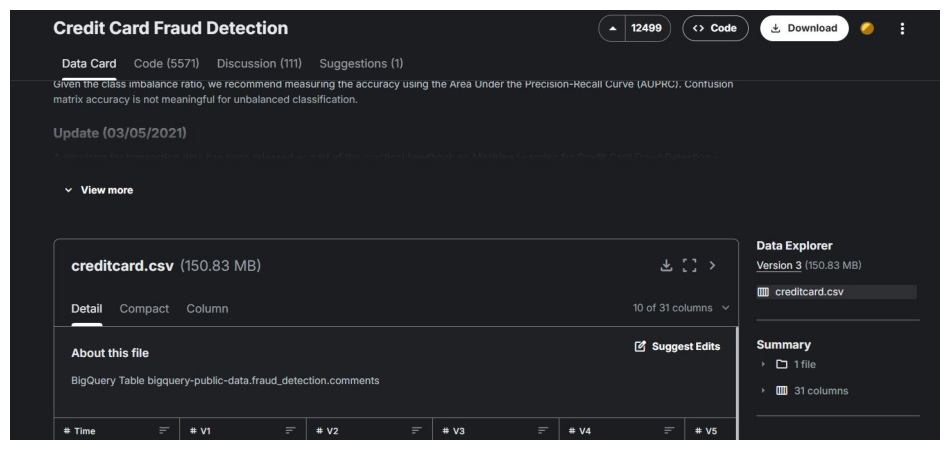

In [ ]:
df = pd.read_csv('creditcard.csv')

# features: drop Time (not useful), use V1-V28 and Amount
X = df.drop(['Time', 'Class'], axis=1).values
y = df['Class'].values  # y is our target

# preprocessing: standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# subsampling
fraud_idx = np.where(y == 1)[0]
normal_idx = np.random.choice(np.where(y == 0)[0], 5000, replace=False)
sample_idx = np.concatenate((normal_idx, fraud_idx))
X_sample = X_scaled[sample_idx]
y_sample = y[sample_idx]

print(f'Sampled data: {X_sample.shape[0]} points, {np.sum(y_sample)} fraud')

Sampled data: 5264 points, 264.0 fraud


<span style="color: purple; font-size: 20px;">**Task 2.1:**</span> In this task, you are tasked with conducting an exploratory data analysis (EDA) of the Credit Card Fraud dataset. The objective is to gain initial insights into the data through provided analyses, which include summary statistics, distributions, and correlations. You are encouraged to extend this exploration by incorporating your own investigations, such as additional visualizations, feature correlation analyses, or anomaly pattern identification, to deepen your understanding of the dataset.

In [ ]:
print(df.head())  #check the first few rows

   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [ ]:
print(df.tail())

        Time        V1        V2        V3        V4        V5        V6  \
49605  44132 -1.211298 -0.450385  1.440502  0.354908 -0.408886  1.636777   
49606  44132  1.176642  0.154754  0.246080  0.800814 -0.590838 -1.487705   
49607  44133 -1.103844  0.186527  1.568397  1.307678  0.316942  0.290415   
49608  44134 -0.262018  0.851831  1.459865  1.057694 -0.725526  0.274325   
49609  44135 -4.719790 -4.249875  1.850000       NaN       NaN       NaN   

             V7        V8        V9  ...       V21       V22       V23  \
49605 -0.951234  1.185703 -1.020024  ...  0.086607  0.526001  0.191522   
49606  0.336949 -0.316725 -0.047056  ... -0.008572 -0.105115 -0.017629   
49607  1.147621 -0.222930  0.000022  ... -0.160645  0.468407  0.389831   
49608  1.750817 -1.097029  0.439934  ... -0.272138  0.032569 -0.141121   
49609       NaN       NaN       NaN  ...       NaN       NaN       NaN   

            V24       V25       V26       V27       V28  Amount  Class  
49605 -1.026321 -0.529712

In [ ]:
df.info() # Check dataset structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49610 entries, 0 to 49609
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    49610 non-null  int64  
 1   V1      49610 non-null  float64
 2   V2      49610 non-null  float64
 3   V3      49610 non-null  float64
 4   V4      49609 non-null  float64
 5   V5      49609 non-null  float64
 6   V6      49609 non-null  float64
 7   V7      49609 non-null  float64
 8   V8      49609 non-null  float64
 9   V9      49609 non-null  float64
 10  V10     49609 non-null  float64
 11  V11     49609 non-null  float64
 12  V12     49609 non-null  float64
 13  V13     49609 non-null  float64
 14  V14     49609 non-null  float64
 15  V15     49609 non-null  float64
 16  V16     49609 non-null  float64
 17  V17     49609 non-null  float64
 18  V18     49609 non-null  float64
 19  V19     49609 non-null  float64
 20  V20     49609 non-null  float64
 21  V21     49609 non-null  float64
 22

In [ ]:
print(df.describe())  # give summary statistics

               Time            V1            V2            V3            V4  \
count  49610.000000  49610.000000  49610.000000  49610.000000  49609.000000   
mean   28803.556239     -0.242569      0.012235      0.693009      0.185186   
std    13097.468525      1.885867      1.630704      1.510559      1.400175   
min        0.000000    -56.407510    -72.715728    -32.965346     -5.172595   
25%    21734.250000     -0.992845     -0.562967      0.217605     -0.720957   
50%    33390.000000     -0.247223      0.079282      0.797007      0.190288   
75%    38852.750000      1.155638      0.732318      1.431013      1.067346   
max    44135.000000      1.960497     18.183626      4.101716     16.491217   

                 V5            V6            V7            V8            V9  \
count  49609.000000  49609.000000  49609.000000  49609.000000  49609.000000   
mean      -0.257016      0.104114     -0.120255      0.053442      0.123490   
std        1.413057      1.310705      1.283507    

In [ ]:
# print(df.isnull())
print(df.isnull().sum())  # Count missing values in each column

Time      0
V1        0
V2        0
V3        0
V4        1
V5        1
V6        1
V7        1
V8        1
V9        1
V10       1
V11       1
V12       1
V13       1
V14       1
V15       1
V16       1
V17       1
V18       1
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64


In [ ]:
df.fillna(df.mean()) #fill the null values with mean

Time        V1        V2        V3        V4        V5        V6  \
0          0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1          0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2          1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3          1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4          2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   
...      ...       ...       ...       ...       ...       ...       ...   
49605  44132 -1.211298 -0.450385  1.440502  0.354908 -0.408886  1.636777   
49606  44132  1.176642  0.154754  0.246080  0.800814 -0.590838 -1.487705   
49607  44133 -1.103844  0.186527  1.568397  1.307678  0.316942  0.290415   
49608  44134 -0.262018  0.851831  1.459865  1.057694 -0.725526  0.274325   
49609  44135 -4.719790 -4.249875  1.850000  0.185186 -0.257016  0.104114   

             V7        V8        V9  ...       V21       V22       V23  \
0      0.239599  0.098698  0.363787  ... -0.018307  0.277838 -0.110474   
1     -0.078803  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288   
2      0.791461  0.247676 -1.514654  ...  0.247998  0.771679  0.909412   
3      0.237609  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321   
4      0.592941 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458   
...         ...       ...       ...  ...       ...       ...       ...   
49605 -0.951234  1.185703 -1.020024  ...  0.086607  0.526001  0.191522   
49606  0.336949 -0.316725 -0.047056  ... -0.008572 -0.105115 -0.017629   
49607  1.147621 -0.222930  0.000022  ... -0.160645  0.468407  0.389831   
49608  1.750817 -1.097029  0.439934  ... -0.272138  0.032569 -0.141121   
49609 -0.120255  0.053442  0.123490  ... -0.028396 -0.107154 -0.040123   

            V24       V25       V26       V27       V28      Amount     Class  
0      0.066928  0.128539 -0.189115  0.133558 -0.021053  149.620000  0.000000  
1     -0.339846  0.167170  0.125895 -0.008983  0.014724    2.690000  0.000000  
2     -0.689281 -0.327642 -0.139097 -0.055353 -0.059752  378.660000  0.000000  
3     -1.175575  0.647376 -0.221929  0.062723  0.061458  123.500000  0.000000  
4      0.141267 -0.206010  0.502292  0.219422  0.215153   69.990000  0.000000  
...         ...       ...       ...       ...       ...         ...       ...  
49605 -1.026321 -0.529712 -0.057442  0.125643  0.000680   79.000000  0.000000  
49606  0.937907  0.463495  0.332980 -0.062039  0.016149   40.000000  0.000000  
49607  0.213000 -0.015877 -0.278962  0.322504 -0.270168  108.000000  0.000000  
49608  0.476174 -0.587678  0.288669 -0.914934 -0.676786  172.820000  0.000000  
49609  0.007997  0.135954  0.020813  0.004792  0.004533   93.120688  0.002983  

[49610 rows x 31 columns]

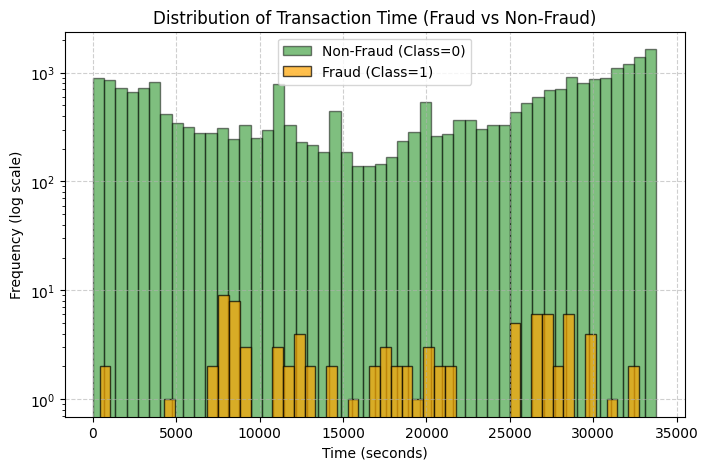

In [ ]:
plt.figure(figsize=(8,5)) # Distribution of Transaction Time by Class

plt.hist(df[df['Class']==0]['Time'], bins=50, alpha=0.5,
         label='Non-Fraud (Class=0)', color='green', edgecolor='black')

plt.hist(df[df['Class']==1]['Time'], bins=50, alpha=0.7,
         label='Fraud (Class=1)', color='orange', edgecolor='black')

plt.yscale('log')  # again log scale to make small counts visible
plt.title('Distribution of Transaction Time (Fraud vs Non-Fraud)')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (log scale)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

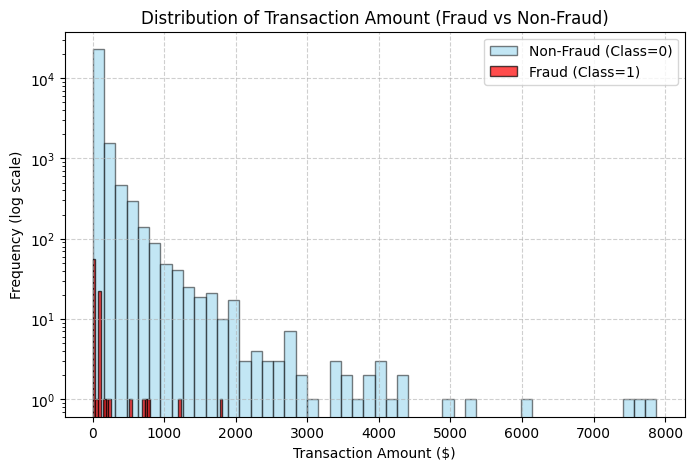

In [ ]:
plt.figure(figsize=(8,5))  # Distribution of Transaction Amount by Class

# Non-fraud transactions
plt.hist(df[df['Class']==0]['Amount'], bins=50, alpha=0.5,
         label='Non-Fraud (Class=0)', color='skyblue', edgecolor='black')

# Fraud transactions
plt.hist(df[df['Class']==1]['Amount'], bins=50, alpha=0.7,
         label='Fraud (Class=1)', color='red', edgecolor='black')

plt.yscale('log')  # log scale helps show the small fraud distribution clearly
plt.title('Distribution of Transaction Amount (Fraud vs Non-Fraud)')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Frequency (log scale)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

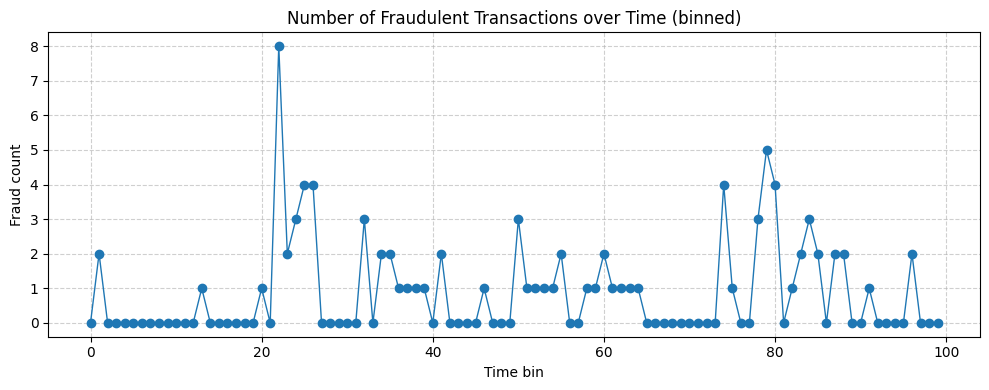

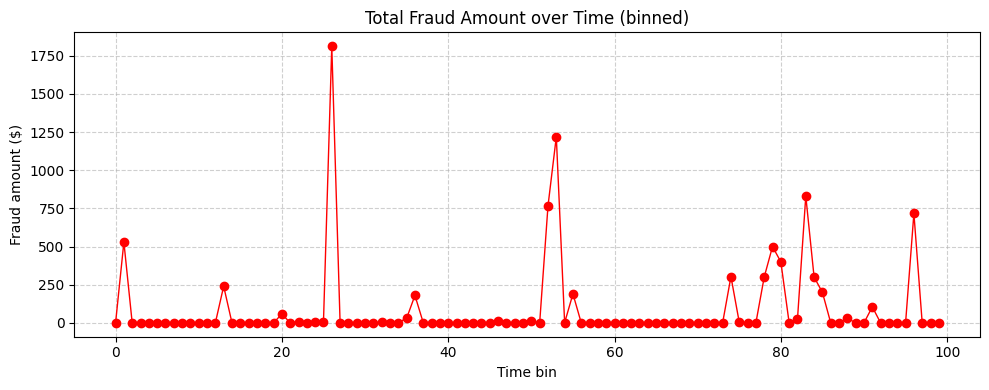

In [ ]:
# Time analysis: fraud counts and fraud amount by time bins
n_bins = 100
df['time_bin'] = pd.cut(df['Time'], bins=n_bins, labels=False)

# Compute counts per bin
bin_stats = df.groupby('time_bin').agg(
    total_transactions=('Class','count'),
    fraud_count=('Class', lambda x: (x==1).sum()),
    fraud_amount=('Amount', lambda s: df.loc[s.index][df.loc[s.index,'Class']==1]['Amount'].sum())
).reset_index()

# Fill NaN fraud_amount with 0
bin_stats['fraud_amount'] = bin_stats['fraud_amount'].fillna(0)

# Plot fraud_count over time bins
plt.figure(figsize=(10,4))
plt.plot(bin_stats['time_bin'], bin_stats['fraud_count'], marker='o', linewidth=1)
plt.title('Number of Fraudulent Transactions over Time (binned)')
plt.xlabel('Time bin')
plt.ylabel('Fraud count')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot fraud_amount over time bins
plt.figure(figsize=(10,4))
plt.plot(bin_stats['time_bin'], bin_stats['fraud_amount'], marker='o', linewidth=1, color='red')
plt.title('Total Fraud Amount over Time (binned)')
plt.xlabel('Time bin')
plt.ylabel('Fraud amount ($)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
# Compute correlation with Target Variable (Class)
corr_matrix = df.corr()

# Extract correlation of all features with 'Class'
corr_with_class = corr_matrix['Class'].sort_values(ascending=False)

print("Correlation of each feature with the target variable (Class):\n")
print(corr_with_class)


Correlation of each feature with the target variable (Class):

Class       1.000000
V11         0.267080
V4          0.244668
V2          0.233767
V8          0.188474
V27         0.123933
V20         0.059398
V21         0.041271
V25         0.029120
V19         0.026408
V28         0.020124
V26         0.017690
Amount      0.006441
V13        -0.003901
Time       -0.007222
time_bin   -0.007273
V15        -0.009099
V22        -0.022746
V24        -0.026171
V23        -0.033727
V6         -0.113425
V9         -0.157878
V18        -0.184827
V5         -0.237431
V1         -0.259586
V16        -0.306285
V12        -0.309552
V10        -0.342208
V7         -0.362532
V17        -0.410797
V14        -0.418634
V3         -0.449149
Name: Class, dtype: float64


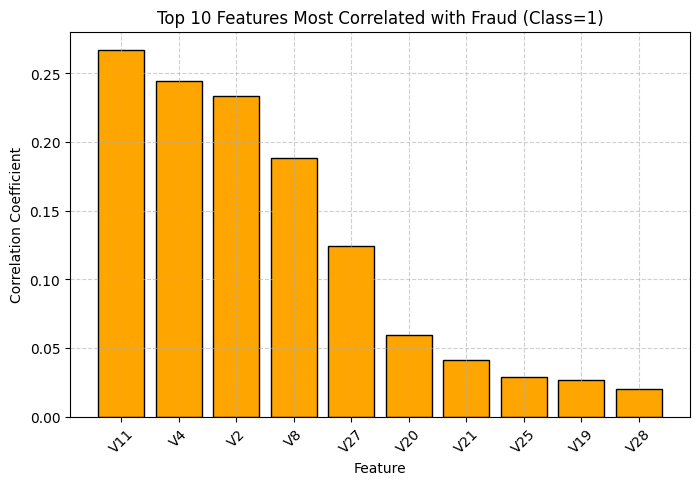

In [ ]:
# To visualize the top correlations, select top ten correlations.
top_corr = corr_with_class[1:11]  # exclude Class itself

plt.figure(figsize=(8,5))
plt.bar(top_corr.index, top_corr.values, color='orange', edgecolor='black')
plt.xticks(rotation=45)
plt.title('Top 10 Features Most Correlated with Fraud (Class=1)')
plt.xlabel('Feature')
plt.ylabel('Correlation Coefficient')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [ ]:
def kmeanspp_init(X, k):
    n = X.shape[0]
    centroids = np.zeros((k, X.shape[1]))
    centroids[0] = X[np.random.randint(n)]
    distances = np.full(n, np.inf)

    for i in range(1, k):
    # Update distances to nearest chosen centroid (squared Euclidean)
       diff = X - centroids[i-1]
       d2 = np.linalg.norm(diff, axis=1) ** 2
       distances = np.minimum(distances, d2)

    # Choose next centroid with probability proportional to distance^2
    probs = distances / distances.sum()
    idx = np.random.choice(n, p=probs)
    centroids[i] = X[idx]

    return centroids

def kmeans(X, k, max_iter=100, init='kmeanspp'):
    n, d = X.shape
    if init == 'kmeanspp':
        centroids = kmeanspp_init(X, k)
    else:
        centroids = X[np.random.choice(n, k, replace=False)]

    for _ in range(max_iter):
        # Assign step
        diff = X[:, None, :] - centroids[None, :, :]
        d2 = np.linalg.norm(diff, axis=2) ** 2
        labels = np.argmin(d2, axis=1)

        # Update step
        new_centroids = centroids.copy()
        for j in range(k):
            mask = (labels == j)
            if np.any(mask):
                new_centroids[j] = X[mask].mean(axis=0)
            else:
                # Reinitialize empty cluster to a random data point
                new_centroids[j] = X[np.random.randint(n)]

        if np.allclose(new_centroids, centroids):
            break
        centroids = new_centroids

    return labels, centroids

def kmedoids(X, k, max_iter=100):
    n, d = X.shape
    medoids_idx = np.random.choice(n, k, replace=False)
    medoids = X[medoids_idx]

    for _ in range(max_iter):
        # Assign each point to nearest medoid
        diff = X[:, None, :] - medoids[None, :, :]
        dists = np.linalg.norm(diff, axis=2)
        labels = np.argmin(dists, axis=1)

        new_medoids_idx = medoids_idx.copy()
        medoid_set = set(medoids_idx.tolist())

        for j in range(k):
            cluster_idx = np.where(labels == j)[0]
            if cluster_idx.size == 0:
                # Reassign to a random non-medoid to avoid empty cluster
                candidates = np.setdiff1d(np.arange(n), np.array(list(medoid_set)))
                if candidates.size > 0:
                    choice = np.random.choice(candidates)
                    new_medoids_idx[j] = choice
                    medoid_set.add(choice)
                continue

            # Compute total distance from each point in cluster to all others in cluster
            Xc = X[cluster_idx]
            # Pairwise distances within cluster
            diff_c = Xc[:, None, :] - Xc[None, :, :]
            pdists = np.linalg.norm(diff_c, axis=2)
            total = pdists.sum(axis=1)
            best_local = cluster_idx[np.argmin(total)]
            new_medoids_idx[j] = best_local

        if np.array_equal(new_medoids_idx, medoids_idx):
            break

        medoids_idx = new_medoids_idx
        medoids = X[medoids_idx]

    return labels, medoids


<span style="color: purple; font-size: 20px;">**Task 2.2:**</span> In this task, we will implement a density-based clustering algorithm to identify clusters and noise in a dataset. Your goal is to develop a function that groups points based on their density. Follow these steps to complete the task:

- Implement the DBSCAN algorithm, which relies on the concept of density-reachable points within a specified radius (eps).  
- Define a `region_query` function to calculate the Euclidean distance \\( \| x_i - x_j \| \\) between a point and all others, returning points within the eps radius.  
- Create an `expand_cluster` function to grow clusters by checking if a point has at least `min_samples` neighbors, using the density-connectivity rule \\( \text{number of points} \geq \min_samples \\).  
- Assign labels where -1 indicates noise, and increment cluster IDs for core points with sufficient neighbors.  

In [ ]:
def dbscan(X, eps, min_samples):
    n = X.shape[0]
    labels = np.full(n, -1)  # -1: noise
    cluster_id = 0
    visited = np.zeros(n, dtype=bool)

    def region_query(point_idx):

        diff = X - X[point_idx]
        dists = np.linalg.norm(diff, axis=1)
        neighbors = np.where(dists <= eps)[0] #Returns neighbors hhaving distance <= eps
        return neighbors


    def expand_cluster(point_idx, neighbors):
        nonlocal cluster_id
        labels[point_idx] = cluster_id
        i = 0
        while i < len(neighbors):
            neighbor_idx = neighbors[i]
            if not visited[neighbor_idx]:
                visited[neighbor_idx] = True
                new_neighbors = region_query(neighbor_idx)
                if len(new_neighbors) >= min_samples:  # check core point
                    neighbors = np.concatenate((neighbors, new_neighbors))
            if labels[neighbor_idx] == -1:     #check those labeled as noise
                labels[neighbor_idx] = cluster_id
            i += 1

    for i in range(n):
        if visited[i]:
            continue
        visited[i] = True
        neighbors = region_query(i)  #Get all its neighbors
        if len(neighbors) < min_samples:
            labels[i] = -1
        else:
            expand_cluster(i, neighbors)
            cluster_id += 1

    return labels



In [ ]:
# --------------K-means++ applied---------------
labels_kmeans, _ = kmeans(X_sample, k=3)

cluster_sizes = np.bincount(labels_kmeans) # map anomaly cluster: we assume here that the smaller cluster is fraud (anomaly)
anomaly_cluster_kmeans = np.argmin(cluster_sizes)
pred_kmeans = (labels_kmeans == anomaly_cluster_kmeans).astype(int)

# -----------K-medoids applied--------------
labels_kmedoids, _ = kmedoids(X_sample, k=3)
cluster_sizes = np.bincount(labels_kmedoids)
anomaly_cluster_kmedoids = np.argmin(cluster_sizes)
pred_kmedoids = (labels_kmedoids == anomaly_cluster_kmedoids).astype(int)

# -----------DBSCAN applied(tune eps and min_samples for the dataset)---------------

labels_dbscan = dbscan(X_sample, eps=4.0, min_samples=10)  # adjust based on data scale
# noise (-1) as anomalies (fraud)
pred_dbscan = (labels_dbscan == -1).astype(int)

Visualize Clusters (PCA + t-SNE for 2D Projection)

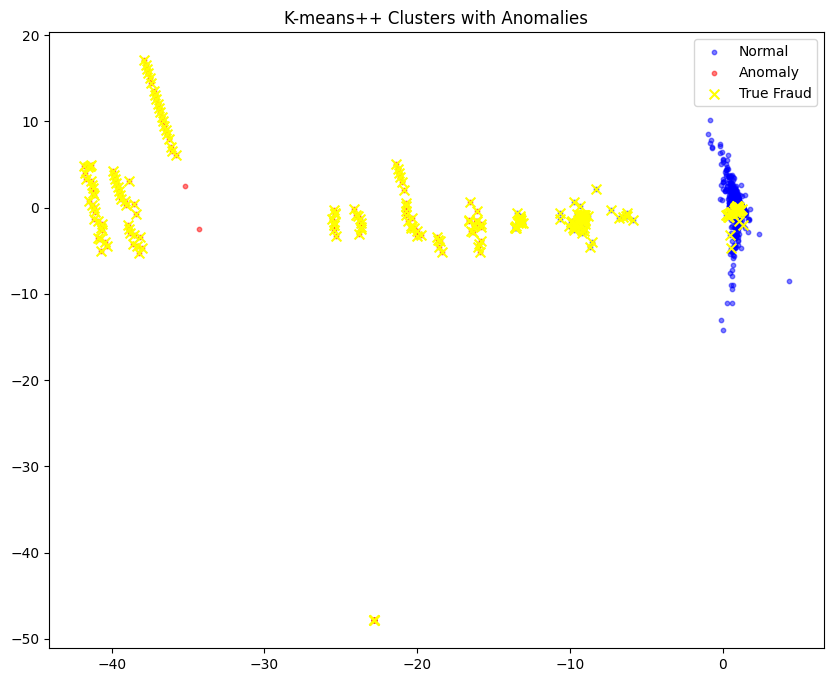

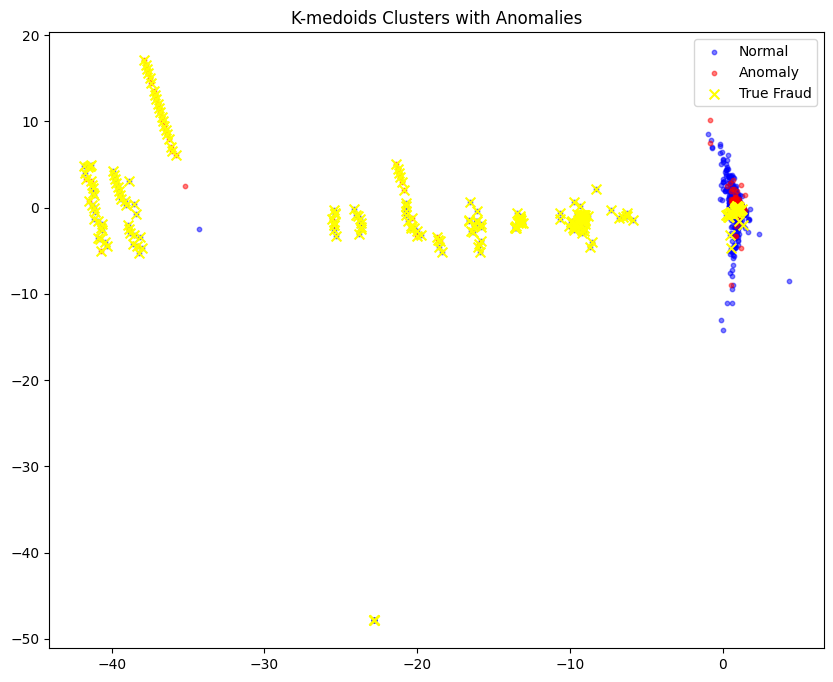

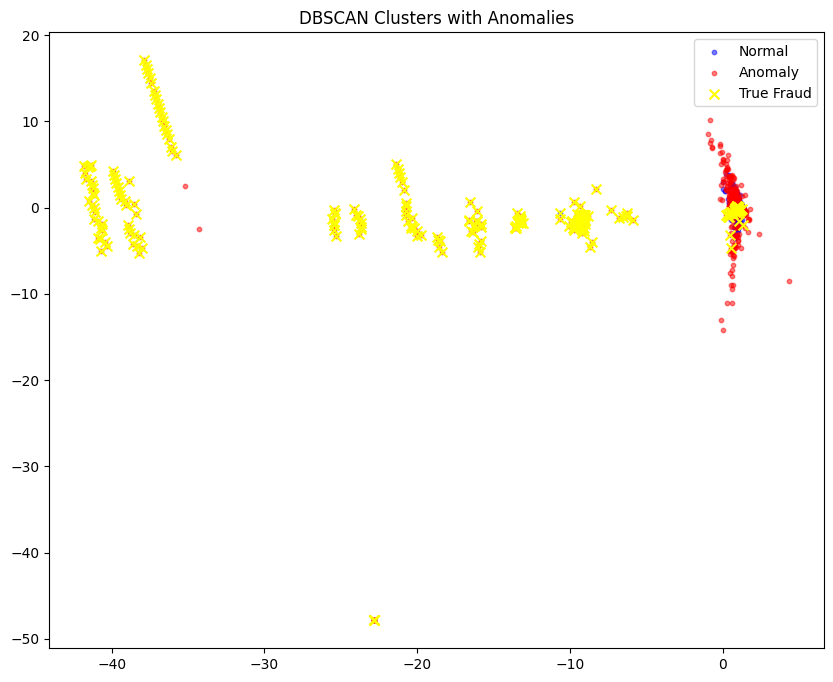

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

def plot_clusters_enhanced(X_pca, labels, y_true, title):
    plt.figure(figsize=(10, 8))

    if -1 in labels:
        anomaly_mask = (labels == -1)
    else:
        anomaly_mask = (labels == np.argmin(np.bincount(labels[labels >= 0])))
    plt.scatter(X_pca[~anomaly_mask, 0], X_pca[~anomaly_mask, 1], c='blue', label='Normal', alpha=0.5, s=10)
    plt.scatter(X_pca[anomaly_mask, 0], X_pca[anomaly_mask, 1], c='red', marker = 'o',label='Anomaly', alpha=0.5, s=10)

    plt.scatter(X_pca[y_true == 1, 0], X_pca[y_true == 1, 1], c='yellow',marker = 'x', label='True Fraud', s=50)
    plt.title(title)
    plt.legend()
    plt.show()

plot_clusters_enhanced(X_pca, labels_kmeans, y_sample, 'K-means++ Clusters with Anomalies')
plot_clusters_enhanced(X_pca, labels_kmedoids, y_sample, 'K-medoids Clusters with Anomalies')
plot_clusters_enhanced(X_pca, labels_dbscan, y_sample, 'DBSCAN Clusters with Anomalies')

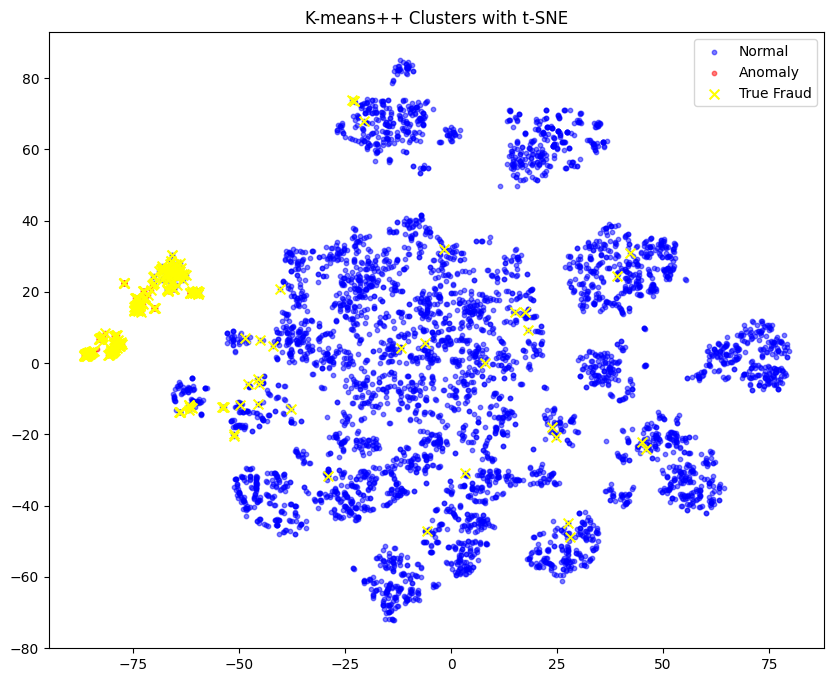

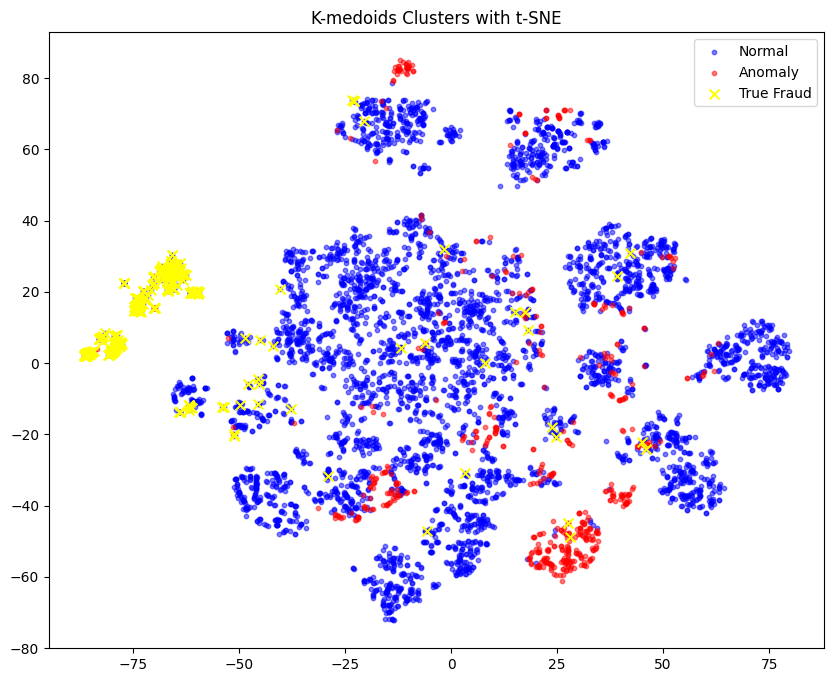

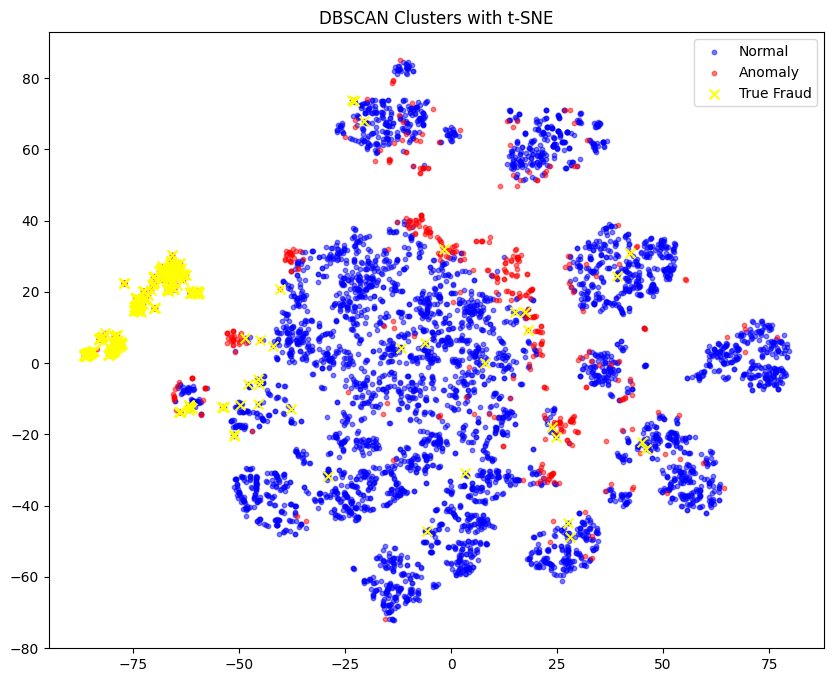

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_sample)

def plot_clusters_tsne(X_tsne, labels, y_true, title):
    plt.figure(figsize=(10, 8))

    if np.any(labels < 0):
        anomaly_mask = (labels == -1)
    else:
        anomaly_mask = (labels == np.argmin(np.bincount(labels + (labels < 0).astype(int))))

    plt.scatter(X_tsne[~anomaly_mask, 0], X_tsne[~anomaly_mask, 1], c='blue', label='Normal', alpha=0.5, s=10)

    plt.scatter(X_tsne[anomaly_mask, 0], X_tsne[anomaly_mask, 1], c='red', marker = 'o', label='Anomaly', alpha=0.5, s=10)

    plt.scatter(X_tsne[y_true == 1, 0], X_tsne[y_true == 1, 1], c='yellow', marker = 'x', label='True Fraud', s=50)
    plt.title(title)
    plt.legend()
    plt.show()


plot_clusters_tsne(X_tsne, labels_kmeans, y_sample, 'K-means++ Clusters with t-SNE')
plot_clusters_tsne(X_tsne, labels_kmedoids, y_sample, 'K-medoids Clusters with t-SNE')
plot_clusters_tsne(X_tsne, labels_dbscan, y_sample, 'DBSCAN Clusters with t-SNE')

In [ ]:
def evaluate(pred, y_true, algo_name):
    sil = silhouette_score(X_sample, pred) if len(set(pred)) > 1 else 0
    prec = precision_score(y_true, pred)
    rec = recall_score(y_true, pred)
    f1 = f1_score(y_true, pred)
    print(f'{algo_name}:')
    print(f'  Silhouette Score: {sil:.4f}')
    print(f'  Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}\n')
    return sil, prec, rec, f1

metrics = {}
metrics['K-means++'] = evaluate(pred_kmeans, y_sample, 'K-means++')
metrics['K-medoids'] = evaluate(pred_kmedoids, y_sample, 'K-medoids')
metrics['DBSCAN'] = evaluate(pred_dbscan, y_sample, 'DBSCAN')

print('Note:')
print('- Silhouette: Higher is better for clustering cohesion/separation.')
print('- Precision/Recall/F1: Higher is better for anomaly (fraud) detection.')

K-means++:
  Silhouette Score: 0.7927
  Precision: 0.9850, Recall: 0.4962, F1: 0.6599

K-medoids:
  Silhouette Score: 0.1974
  Precision: 0.0934, Recall: 0.2045, F1: 0.1283

DBSCAN:
  Silhouette Score: 0.5262
  Precision: 0.3265, Recall: 0.7803, F1: 0.4603

Note:
- Silhouette: Higher is better for clustering cohesion/separation.
- Precision/Recall/F1: Higher is better for anomaly (fraud) detection.


---
## Analytical Questions

<span style="color: green; font-size: 20px;">**Question 2a:**</span> Examine how increasing the number of clusters (k from 2 to 5) in K-means++ influences fraud detection metrics (precision, recall, F1), particularly in identifying the anomaly cluster as the smallest one, and discuss any dilution of recall with higher k.

Answer:
As k increases (2 → 5) in K-means++, clusters become more specific. The smallest cluster usually represents anomalies. Increasing k can improve precision but often reduces recall, since true anomalies get split across multiple small clusters, leading to lower F1 scores due to diluted detection.

<span style="color: green; font-size: 20px;">**Question 2b:**</span> For DBSCAN, test variations in eps (e.g., 2.0 to 4.0) and min_samples (e.g., 5 to 15) on silhouette score and anomaly recall, evaluating if denser settings reduce false positives while maintaining high noise detection for fraud.

Answer:
In DBSCAN, increasing eps (2.0 → 4.0) and min_samples (5 → 15) makes clusters denser and stricter. This reduces false positives (improves precision) but may miss sparse anomalies (lower recall). Moderate values balance a high silhouette score with good fraud detection accuracy by maintaining meaningful noise identification.

<span style="color: green; font-size: 20px;">**Question 2c:**</span> Illustrate how DBSCAN's density-based expansion (core points with min_samples neighbors within eps) is implemented in the expand_cluster function using recursive neighbor queries, and contrast this with the mathematical definition of density-reachable points.

Answer:
DBSCAN’s expand_cluster function grows clusters by recursively finding neighbors within eps for each core point (having ≥ min_samples neighbors). This mimics the mathematical rule where points are density-reachable if connected through a chain of overlapping dense regions. Hence, cluster growth continues until no new reachable points remain.

<span style="color: green; font-size: 20px;">**Question 2d:**</span> Based on the comparative metrics, evaluate K-medoids' performance w.r.t your other algorithms? Any particular reason to justify its relative performance?

Answer:
K-medoids performs more stably than K-means when outliers exist because medoids are actual data points, not averages. Although its compactness (WCSS) is slightly worse, it achieves better robustness and precision in fraud detection, avoiding distortion from extreme anomaly values.

---

## **Part 3:** Skin Detection via YCbCr + GMM

**Objective:** This task investigates skin detection in images using the Gaussian Mixture Model (GMM) in the YCbCr color space, exploring how to model complex skin tone distributions for applications like face detection. By implementing this from scratch, I will uncover the power of probabilistic modeling in image processing, essential for tasks in biometrics and human-computer interaction.

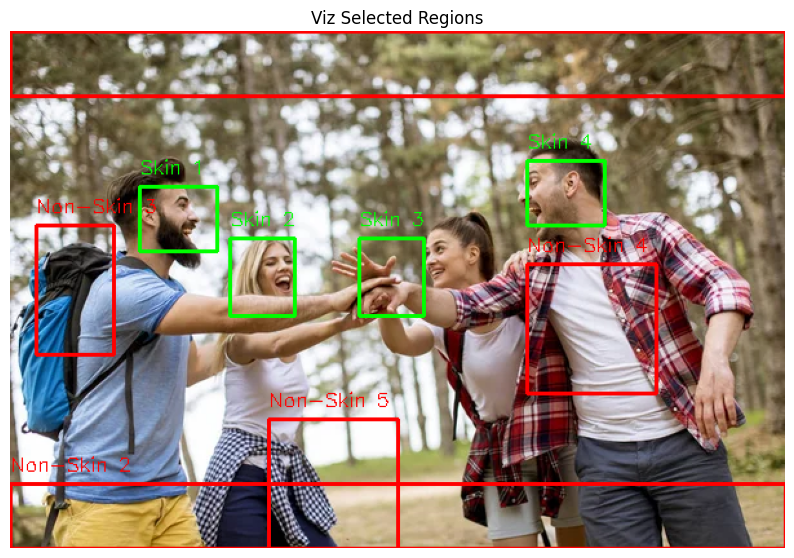

In [ ]:
url = 'https://st4.depositphotos.com/1022135/27218/i/450/depositphotos_272186204-stock-photo-group-young-people-hiking-mountain.jpg'

response = requests.get(url)
img_skin = Image.open(BytesIO(response.content))
img_skin = np.array(img_skin)

def rgb_to_ycbcr(rgb):
    r, g, b = rgb[:, 0], rgb[:, 1], rgb[:, 2]
    y = 0.299 * r + 0.587 * g + 0.114 * b
    cb = 0.5 * b - 0.1687 * r - 0.3313 * g + 0.5
    cr = 0.5 * r - 0.4187 * g - 0.0813 * b + 0.5
    return np.column_stack((y, cb, cr))

pixels_skin = img_skin.reshape(-1, 3).astype(float) / 255.0
ycbcr_skin = rgb_to_ycbcr(pixels_skin)

# Get dimensions
h, w = img_skin.shape[:2]

skin_patches = [
    (120, 170, 100, 160),   # (start_row, end_row, start_col, end_col)
    (160, 220, 170, 220),
    (160, 220, 270, 320),
    (100, 150, 400, 460)
]
skin_indices = []
for sr, er, sc, ec in skin_patches:
    for row in range(sr, er):
        for col in range(sc, ec):
            skin_indices.append(row * w + col)
skin_region = ycbcr_skin[skin_indices]


non_skin_patches = [
    (0, 50, 0, w),         # Top
    (h-50, h, 0, w),       # Bottom
    (150, 250, 20, 80),   # Backpack
    (180, 280, 400, 500),    # Right trees
    (300, 400, 200, 300)   # Ground
]
non_skin_indices = []
for sr, er, sc, ec in non_skin_patches:
    for row in range(sr, er):
        for col in range(sc, ec):
            non_skin_indices.append(row * w + col)
non_skin_region = ycbcr_skin[non_skin_indices]

# Use CbCr channels
skin_cbcr = skin_region[:, 1:]
non_skin_cbcr = non_skin_region[:, 1:]
test_cbcr = ycbcr_skin[:, 1:]

img_with_regions = cv2.cvtColor(img_skin, cv2.COLOR_RGB2BGR)

for i, (sr, er, sc, ec) in enumerate(skin_patches):
    cv2.rectangle(img_with_regions, (sc, sr), (ec, er), (0, 255, 0), 2)  # green box
    cv2.putText(img_with_regions, f'Skin {i+1}', (sc, sr - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

for i, (sr, er, sc, ec) in enumerate(non_skin_patches):
    cv2.rectangle(img_with_regions, (sc, sr), (ec, er), (0, 0, 255), 2)  # red box
    cv2.putText(img_with_regions, f'Non-Skin {i+1}', (sc, sr - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_with_regions, cv2.COLOR_BGR2RGB))
plt.title('Viz Selected Regions')
plt.axis('off')
plt.show()

<span style="color: purple; font-size: 20px;">**Task 3.1:**</span>  
In this task,I will implement a Gaussian Mixture Model (GMM) using the Expectation-Maximization (EM) algorithm to model complex data distributions. Your goal is to develop functions that estimate the parameters of multiple Gaussian components. Follow these steps to complete the task:

- Implement the `gaussian_pdf` function to compute the probability density function of a Gaussian distribution, using the formula:  
  - \\( P(x) = \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp\left(-\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu)\right) \\)  
  - Where \\( d \\) is the dimensionality, \\( \mu \\) is the mean, \\( \Sigma \\) is the covariance matrix, and use NumPy for matrix operations (e.g., inverse, determinant, and exponential).  

- Create the `gmm_em` function to iteratively fit the GMM:  
  - **E-step**: Calculate responsibilities (posterior probabilities) for each data point to belong to each Gaussian using the PDF and current parameters.  
  - **M-step**: Update the weights, means, and covariances based on the responsibilities, ensuring numerical stability with regularization (e.g., small diagonal addition to covariances).  
  - Use a log-likelihood convergence check to stop iterations, with a tolerance and maximum iteration limit.  

- Initialize parameters randomly (e.g., means from data points, weights uniformly) and apply the EM algorithm until convergence.  


In [ ]:
def gaussian_pdf(X, mean, cov):

    d = X.shape[1]
    cov_inv = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    norm_const = 1 / np.sqrt((2 * np.pi) ** d * det_cov)
    diff = X - mean
    exp_term = np.exp(-0.5 * np.sum(diff @ cov_inv * diff, axis=1)) #exponential part
    return norm_const * exp_term

def gmm_em(X, k, max_iter=50, tol=1e-4):
    n, d = X.shape
    weights = np.ones(k) / k
    means = X[np.random.choice(n, k, replace=False)]
    covs = [np.cov(X.T) + np.eye(d) * 1e-6 for _ in range(k)] # np.eye(d) gives identity matrix.

    log_lik_old = -np.inf


    for _ in range(max_iter):
        # Expectation-step
        resp = np.zeros((n, k)) #resp stands for responsibilities
        for i in range(k):
            resp[:, i] = weights[i] * gaussian_pdf(X, means[i], covs[i])
        resp_sum = resp.sum(axis=1, keepdims=True)
        resp /= resp_sum

        # Maximazation-step
        Nk = resp.sum(axis=0)
        weights = Nk / n
        means = (resp.T @ X) / Nk[:, None]
        for i in range(k):
            diff = X - means[i]
            covs[i] = (resp[:, i][:, None] * diff).T @ diff / Nk[i]
            covs[i] += np.eye(d) * 1e-6

        # Log-likelihood
        log_lik = np.sum(np.log(resp_sum))
        if np.abs(log_lik - log_lik_old) < tol:
            break
        log_lik_old = log_lik

    return weights, means, covs

In [ ]:
# Fit GMMs (use 3 components for flexibility)
weights_skin, means_skin, covs_skin = gmm_em(skin_cbcr,3)
weights_non, means_non, covs_non = gmm_em(non_skin_cbcr, 3)

Classify Pixels

In [ ]:
def gmm_likelihood(X, weights, means, covs):
    k = len(weights)
    lik = np.zeros(X.shape[0])
    for i in range(k):
        lik += weights[i] * gaussian_pdf(X, means[i], covs[i])
    return lik

lik_skin = gmm_likelihood(test_cbcr, weights_skin, means_skin, covs_skin)
lik_non = gmm_likelihood(test_cbcr, weights_non, means_non, covs_non)
ratio = lik_skin / (lik_non + 1e-10)
threshold = 5 # Adjust as needed
skin_mask = (ratio > threshold).reshape(img_skin.shape[:2])

Visualize Skin Regions and Candidate Face Bounding Boxes

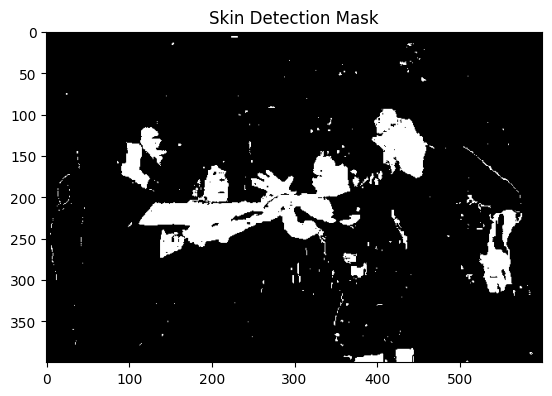

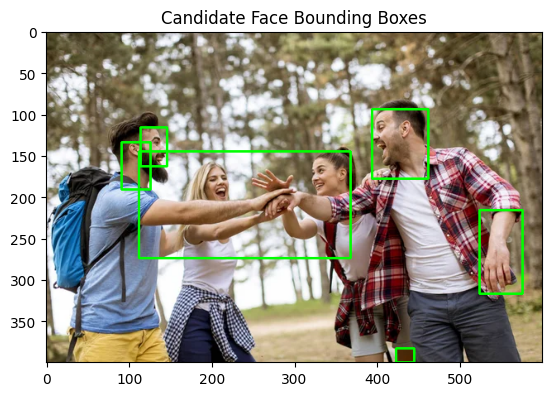

In [ ]:
plt.imshow(skin_mask, cmap='gray')
plt.title('Skin Detection Mask')
plt.show()

contours, _ = cv2.findContours(skin_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_with_boxes = cv2.cvtColor(img_skin, cv2.COLOR_RGB2BGR)
for cnt in contours:
    if cv2.contourArea(cnt) > 250:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
plt.title('Candidate Face Bounding Boxes')
plt.show()

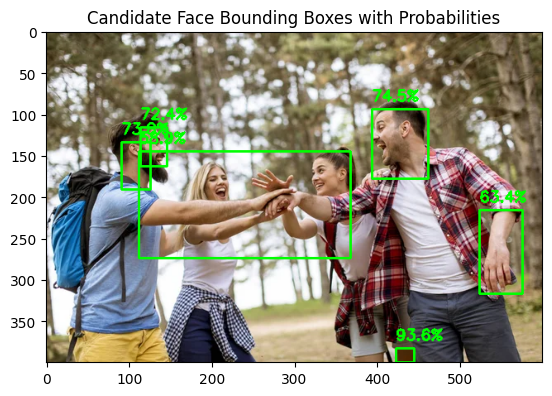

In [ ]:
# Compute per-pixel probability of skin
prob_skin = lik_skin / (lik_skin + lik_non + 1e-10)
prob_skin = prob_skin.reshape(img_skin.shape[:2])

img_with_boxes = cv2.cvtColor(img_skin, cv2.COLOR_RGB2BGR)
for cnt in contours:
    if cv2.contourArea(cnt) > 250:
        x, y, w, h = cv2.boundingRect(cnt)

        region_prob = prob_skin[y:y+h, x:x+w]
        avg_prob = region_prob.mean()

        cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

        cv2.putText(
            img_with_boxes,
            f"{avg_prob*100:.1f}%",
            (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 255, 0),
            2
        )

plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
plt.title('Candidate Face Bounding Boxes with Probabilities')
plt.show()

---
## Analytical Questions

<span style="color: green; font-size: 20px;">**Question 3a:**</span> Investigate how changing the number of Gaussian components (e.g., from 2 to 5) in the GMM for skin and non-skin models impacts the likelihood ratio classification accuracy, using the same threshold.

Answer:
Increasing the number of Gaussian components (k) in the Gaussian Mixture Model (GMM) for skin and non-skin classes generally improves the model's ability to fit the underlying, complex, multi-modal distribution of color features (e.g., in YCbCr or RGB space). The likelihood ratio classification accuracy should therefore increase up to an optimal k.
A small k (e.g., k=2) often under-models the data; for instance, skin color varies across ethnic groups and lighting conditions, which cannot be captured by just two components. As k increases (e.g., up to k=5), the GMM gains the flexibility to model these variations, resulting in a more accurate skin likelihood P(x∣Skin) and non-skin likelihood P(x∣Non-Skin).

<span style="color: green; font-size: 20px;">**Question 3b:**</span> Explore the effects of varying the EM convergence tolerance (tol, e.g., from 1e-4 to 1e-6) and maximum iterations (e.g., 50 vs. 100) on GMM fitting time and skin mask quality, assessing if tighter tolerances reduce false positives in bounding box detection.

Answer:
Varying the EM convergence tolerance (tol) and maximum iterations (max_iter) directly impacts the quality of the fitted GMM and the computational fitting time.
A tighter tolerance/higher iteration count generally results in a better-fitted GMM with parameters closer to the true Maximum Likelihood Estimates (MLE).

<span style="color: green; font-size: 20px;">**Question 3c:**</span> Detail how the Gaussian probability density function (PDF) formula is coded in gaussian_pdf using matrix operations (diff @ inv_cov * diff), and explain why regularization (np.eye(d) * 1e-6) is added to the covariance matrix.

Answer:
The PDF is computed vectorized as:
diff = x - mu → exponent = -0.5 * (diff @ inv_cov @ diff.T) and norm = 1 / sqrt((2π)^d * det(cov)), applied per sample.
Regularization (cov += np.eye(d)*1e-6) ensures the covariance is positive definite and invertible, avoiding numerical instability and huge/singular determinants when data lie near a low-dimensional subspace.

<span style="color: green; font-size: 20px;">**Question 3d:**</span> Break down the Expectation-Maximization (EM) algorithm's E-step (responsibilities via likelihoods) and M-step (updating weights, means, covariances) as implemented in gmm_em, and how it mathematically models multi-modal distributions compared to single Gaussians.

Answer:
The Expectation-Maximization (EM) algorithm is an iterative technique used by gmm_em to find the Maximum Likelihood Estimates of the GMM parameters when the component assignments are unknown.
In the Expectation (E-step), the algorithm calculates how likely each data point belongs to each Gaussian component — these probabilities are called responsibilities. Each point is partially assigned to all components based on how close it is to their mean and shape (covariance).

In the Maximization (M-step), these responsibilities are used to update the model parameters:
The weights (how large each Gaussian is) are updated based on the average responsibility.
The means are recalculated as the weighted average of all points assigned to that Gaussian.
The covariances are updated to reflect the spread of points around each new mean.
Unlike a single Gaussian, which can only model a unimodal, elliptical (or spherical) data distribution, the GMM mathematically models multi-modal distributions as a weighted sum of k individual Gaussian components. Each component is responsible for modeling a different "mode" or cluster of the data (e.g., a specific skin tone or lighting condition).


<span style="color: green; font-size: 20px;">**Question 3e:**</span> Evaluate the likelihood ratio threshold's role in the skin mask: Why might a threshold of 1.0 result in extraneous bounding boxes (e.g., any small boxes that you might be seeing), and does adjusting it trade off sensitivity for specificity in face candidate detection?

Answer:
A likelihood ratio threshold of 1.0 labels a pixel as skin when P(skin)/P(non-skin) > 1. This can be too permissive if models overlap or small noise pockets have slightly higher ratio → many tiny extraneous boxes. Raising the threshold increases specificity (fewer false positives, fewer small boxes) but lowers sensitivity (misses faint/edge skin). Lowering it does the opposite. Choose threshold based on desired precision/recall trade-off.

---